### Boosting的範例

中文字型已設定為 'ChineseFont'
心臟病數據集前5行:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

數據集維度: (303, 14)

數據集缺失值統計:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

類別型特徵: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
數值型特徵: ['age'

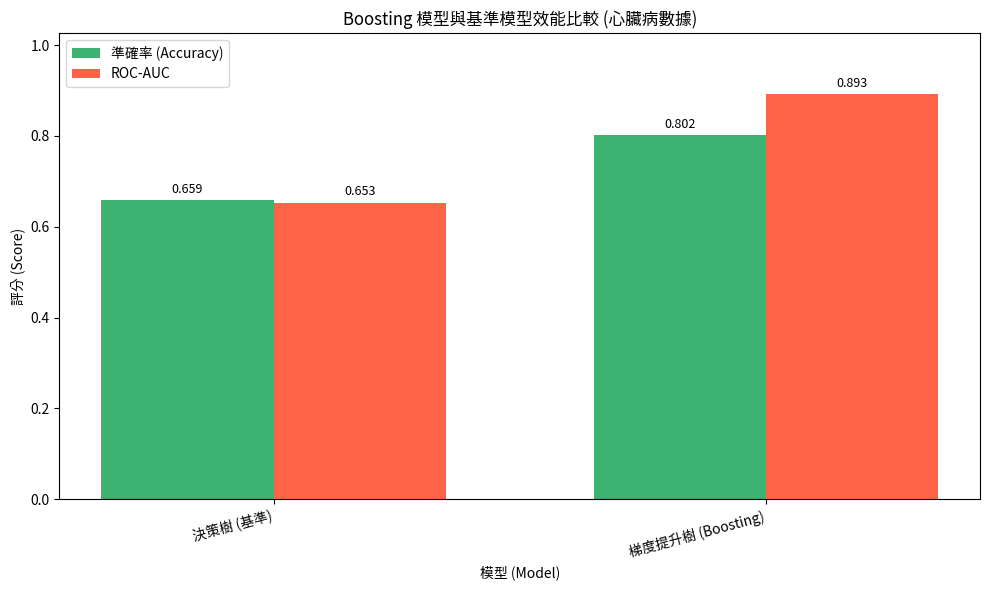

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # 用於處理缺失值
from sklearn.pipeline import Pipeline

# 模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 評估指標
from sklearn.metrics import accuracy_score, roc_auc_score

# 繪圖相關
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# --- 中文字型設定 ---
# 假設您已在筆記本前面儲存格成功下載並使 fontManager 知道 "ChineseFont.ttf"
try:
    fontManager.addfont("ChineseFont.ttf")
    mpl.rc('font', family="ChineseFont")
    print("中文字型已設定為 'ChineseFont'")
except Exception as e:
    print(f"中文字型設定失敗: {e}。圖表可能無法正確顯示中文。")
    pass

# --- 1. 數據載入 (Heart Disease UCI) ---
# 資料來源說明: https://archive.ics.uci.edu/ml/datasets/Heart+Disease
# 我們將使用 processed.cleveland.data，它相對乾淨一些
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
# 數據集沒有表頭，需要手動定義欄位名稱
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
data = pd.read_csv(data_url, header=None, names=column_names, na_values='?') # '?' 代表缺失值

print("心臟病數據集前5行:")
print(data.head())
print(f"\n數據集維度: {data.shape}")
print(f"\n數據集缺失值統計:\n{data.isnull().sum()}")

# --- 2. 數據預處理 ---
# 目標變數 'target': 0 = 健康, >0 = 不同程度的心臟病。我們將其轉換為二元分類：0 = 健康, 1 = 有心臟病
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

X = data.drop(columns=['target'])
y = data['target']

# 識別類別型和數值型特徵
# 根據數據集描述，以下是明確的類別型特徵 (即使它們是數值表示)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = [col for col in X.columns if col not in categorical_features]

print(f"\n類別型特徵: {categorical_features}")
print(f"數值型特徵: {numerical_features}")

# 創建預處理管道
# 對數值型特徵：缺失值用中位數填充，然後標準化
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 對類別型特徵：缺失值用最頻繁值填充，然後進行 OneHotEncoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' 避免共線性
])

# 使用 ColumnTransformer 整合數值和類別轉換器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 分割訓練和測試數據
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 對訓練數據進行擬合和轉換，對測試數據僅進行轉換
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 獲取 OneHotEncoder 生成的特徵名稱 (如果需要，用於特徵重要性分析等)
# try:
#     feature_names_out = preprocessor.get_feature_names_out()
#     print(f"\n處理後的特徵名稱 (部分): {feature_names_out[:10]}")
# except AttributeError: # 老版本 sklearn 可能沒有 get_feature_names_out
#     print("\n無法自動獲取處理後的特徵名稱 (get_feature_names_out 不可用)")
#     pass


print(f"\n處理後的訓練數據維度: {X_train_processed.shape}")
print(f"處理後的測試數據維度: {X_test_processed.shape}")

# --- 3. 模型定義、訓練與評估 ---
model_names_plot = []
accuracies_plot = []
roc_aucs_plot = []

# 3.1 基礎模型: 決策樹 (用於比較)
dt_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_clf.fit(X_train_processed, y_train)
dt_pred = dt_clf.predict(X_test_processed)
dt_proba = dt_clf.predict_proba(X_test_processed)[:, 1]
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_roc_auc = roc_auc_score(y_test, dt_proba)

model_names_plot.append('決策樹 (基準)')
accuracies_plot.append(dt_accuracy)
roc_aucs_plot.append(dt_roc_auc)
print(f"\n--- 決策樹 (基準) 效能 ---")
print(f"決策樹 - 準確率: {dt_accuracy:.4f}, ROC-AUC: {dt_roc_auc:.4f}")

# 3.2 Boosting 模型: Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train_processed, y_train)
gb_pred = gb_clf.predict(X_test_processed)
gb_proba = gb_clf.predict_proba(X_test_processed)[:, 1]
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_proba)

model_names_plot.append('梯度提升樹 (Boosting)')
accuracies_plot.append(gb_accuracy)
roc_aucs_plot.append(gb_roc_auc)
print(f"\n--- 梯度提升樹 (Boosting) 效能 ---")
print(f"梯度提升樹 - 準確率: {gb_accuracy:.4f}, ROC-AUC: {gb_roc_auc:.4f}")


# --- 4. 繪製效能比較圖表 ---
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(model_names_plot))

rects1 = plt.bar(index, accuracies_plot, bar_width, label='準確率 (Accuracy)', color='mediumseagreen')
rects2 = plt.bar(index + bar_width, roc_aucs_plot, bar_width, label='ROC-AUC', color='tomato')

plt.xlabel('模型 (Model)')
plt.ylabel('評分 (Score)')
plt.title('Boosting 模型與基準模型效能比較 (心臟病數據)')
plt.xticks(index + bar_width / 2, model_names_plot, rotation=15, ha="right")
plt.ylim(0, max(max(accuracies_plot, default=0), max(roc_aucs_plot, default=0)) * 1.15 if accuracies_plot or roc_aucs_plot else 1.05)
plt.legend()

def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

current_ax = plt.gca()
autolabel(rects1, current_ax)
autolabel(rects2, current_ax)

plt.tight_layout()

# --- 5. 儲存並顯示圖表 ---
chart_filename = 'heart_disease_boosting_performance_comparison.png'
plt.savefig(chart_filename)
print(f"\n圖表已儲存為: {chart_filename}")
plt.show()

# (可選) 顯示 Gradient Boosting 的特徵重要性
# if hasattr(gb_clf, 'feature_importances_'):
#     try:
#         # 嘗試獲取處理後的特徵名稱
#         feature_names_out = preprocessor.get_feature_names_out()
#         importances = gb_clf.feature_importances_
#         feature_importance_df = pd.DataFrame({'特徵': feature_names_out, '重要性': importances})
#         feature_importance_df = feature_importance_df.sort_values(by='重要性', ascending=False).head(15) # 取前15個

#         plt.figure(figsize=(10, 8))
#         plt.title('梯度提升樹 - 特徵重要性 (前15)')
#         plt.barh(feature_importance_df['特徵'], feature_importance_df['重要性'], color='lightgreen')
#         plt.xlabel('重要性分數')
#         plt.ylabel('特徵')
#         plt.gca().invert_yaxis()
#         plt.tight_layout()
#         plt.savefig('heart_disease_gb_feature_importance.png')
#         print("\n特徵重要性圖表已儲存為: heart_disease_gb_feature_importance.png")
#         plt.show()
#     except Exception as e:
#         print(f"\n繪製特徵重要性圖表時出錯: {e} (可能是因為 get_feature_names_out 不可用或特徵名稱不匹配)")
#         # 如果無法獲取特徵名稱，可以只顯示重要性分數，但可讀性較差
#         # importances = gb_clf.feature_importances_
#         # sorted_indices = np.argsort(importances)[::-1]
#         # plt.figure(figsize=(10, 6))
#         # plt.title('梯度提升樹 - 特徵重要性 (索引)')
#         # plt.bar(range(X_train_processed.shape[1]), importances[sorted_indices], align='center')
#         # plt.xticks(range(X_train_processed.shape[1]), sorted_indices)
#         # plt.xlabel('特徵索引')
#         # plt.ylabel('重要性')
#         # plt.show()



**程式碼說明：**

1. **數據載入**：
    - 從 UCI Machine Learning Repository 下載 `processed.cleveland.data` 文件。
    - 為數據集手動定義了欄位名稱。
    - 在讀取 CSV 時，將 `'?'` 符號指定為缺失值 (`na_values='?'`)。
1. **數據預處理**：
    - **目標變數轉換**：原始數據中，`target` 欄位 0 代表健康，1-4 代表不同程度的心臟病。這裡將其簡化為二元分類問題：0 代表健康，1 代表有心臟病。
    - **特徵類型識別**：根據數據集描述，明確區分了類別型和數值型特徵。
    - **缺失值處理**：
        - 對於數值型特徵，使用 `SimpleImputer` 以該列的中位數 (`strategy='median'`) 填充缺失值。
        - 對於類別型特徵，使用 `SimpleImputer` 以該列的最頻繁值 (`strategy='most_frequent'`) 填充缺失值。
    - **特徵轉換**：
        - 數值型特徵在填充缺失值後進行 `StandardScaler` 標準化。
        - 類別型特徵在填充缺失值後進行 `OneHotEncoder` 獨熱編碼。`handle_unknown='ignore'` 確保測試集出現新類別時不會報錯，`drop='first'` 用於減少共線性。
    - **`ColumnTransformer`**：用於將上述針對不同類型特徵的預處理步驟整合起來。
    - **數據分割**：使用 `train_test_split` 分割數據，並透過 `stratify=y` 確保訓練集和測試集中的類別比例與原始數據集相似。
1. **模型訓練與評估**：
    - **決策樹 (基準)**：訓練一個單獨的決策樹模型作為比較基準。
    - **梯度提升分類器 (Boosting)**：訓練 `GradientBoostingClassifier`。
        - `n_estimators=100`：提升樹的數量。
        - `learning_rate=0.1`：學習率。
        - `max_depth=3`：每棵樹的最大深度。
    - 計算兩個模型的準確率和 ROC-AUC 分數，並將結果儲存起來用於繪圖。
1. **繪製效能比較圖表**：
    - 使用 `matplotlib` 繪製長條圖，比較決策樹和梯度提升樹在準確率和 ROC-AUC 上的表現。
    - 圖表標題和儲存檔名已更新，以反映這是心臟病數據集的 Boosting 效能比較。
1. **（可選）特徵重要性圖表**：
    - 程式碼中包含了一段被註解掉的內容，用於顯示梯度提升模型的特徵重要性。如果您的 `sklearn` 版本支持 `get_feature_names_out()` 並且預處理步驟順利，您可以取消註解這部分來生成特徵重要性圖。這有助於理解哪些特徵對模型的預測貢獻最大。

執行此儲存格後，您將看到數據載入、預處理的相關信息，接著是決策樹和梯度提升模型的性能指標輸出，最後會顯示並儲存一個比較它們效能的長條圖。如果取消註解，還會顯示特徵重要性圖。

這個範例使用了與您之前不同的數據集，並展示了 Boosting 演算法（梯度提升樹）的應用。